# Brain mri segmentation

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Выгрузка-данных-и-адаптация" data-toc-modified-id="Выгрузка-данных-и-адаптация-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Выгрузка данных и адаптация</a></span></li><li><span><a href="#Визуализация-данных" data-toc-modified-id="Визуализация-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Визуализация данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Оценка-полученных-результатов" data-toc-modified-id="Оценка-полученных-результатов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Оценка полученных результатов</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

Нам предстоит решение задачи сегментации на основе датасета, состоящего из МРТ снимков 110 пациентов и соответствующих им масок, обозначающих наличие у того или иного пациента опухоли. Данные взяты с соревнования на Kaggle - [Brain MRI segmentation](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation).

In [1]:
import numpy as np 
import pandas as pd

import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split

import torchvision
from torchvision import datasets,transforms
import albumentations as A
import cv2

torch.manual_seed(42)

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 10
LEARNING_RATE = 1e-3
EPOCH = 50

## Выгрузка данных и адаптация

Зададим путь к папке с файлами датасета.

In [3]:
path_folder = 'S:/kaggle/lgg-mri-segmentation/kaggle_3m/'

Разделим данные на обучающую, валидационную и тестовую выборки. Несколько изменим исходную [задачу](https://arxiv.org/pdf/1906.03720.pdf). В данном случае будем использовать только те пары **маска-изображение**, где имеется опухоль. 

In [4]:
def data_spliter(path):
    
    masks = glob.glob(path + '*/*_mask*')
    images = [image.replace('_mask', '') for image in masks]

    masks_names = [mask.replace(path, '') for mask in masks]
    images_names = [image.replace(path, '') for image in images]
    
    def labeling(mask_name):
        
        if np.max(cv2.imread(os.path.join(path, mask_name), cv2.IMREAD_GRAYSCALE)) > 0:
            
            return 1
        
        return 0

    df = pd.DataFrame({'masks_names' : masks_names,
                       'images_names' : images_names,
                       'label' : [labeling(i) for i in masks_names]})
    
    df = df.loc[df['label']==1]

    features_train, features_valid, target_train, target_valid = train_test_split(df['images_names'],
                                                                                  df['masks_names'],
                                                                                  train_size=.6,
                                                                                  random_state=42)

    features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                                target_valid,
                                                                                train_size=.5,
                                                                                random_state=42)

    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [5]:
features_train, features_valid, features_test, target_train, target_valid, target_test = data_spliter(path_folder)

Определим класс, преобразующий исходные изображения к формату `torch.Tensor`.

In [6]:
class Tumor_dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, masks_names, images_names, transform=None):
        
        self.path = path

        self.masks_names = list(masks_names)
        self.images_names = list(images_names)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.masks_names)
    
    def __getitem__(self, index):
        
        #mask preprocessing 
        masks_names = self.masks_names[index]
        pic_mask = cv2.imread(os.path.join(self.path, masks_names), cv2.IMREAD_GRAYSCALE)
        #256x256 to 128x128
        pic_mask = cv2.resize(pic_mask,(IMAGE_SIZE, IMAGE_SIZE))
        #filter out mask after resizing
        pic_mask = (pic_mask>1)*1
        #reshape mask to show number of layers
        pic_mask = np.array([pic_mask])
        
        #input image preprocessing
        images_name = self.images_names[index]
        pic_image = cv2.imread(os.path.join(self.path, images_name))
        #256x256 to 128x128
        pic_image = cv2.resize(pic_image,(IMAGE_SIZE, IMAGE_SIZE))
        #normalize from 0 to 1
        pic_image = pic_image / 255
        #transpose to obtain acceptable array format for torch
        pic_image = pic_image.transpose((2, 0, 1))
        #pic_image = np.array([pic_image])
        
        #augmentation
        if self.transform is not None:
            aug = self.transform(image=pic_image, mask=pic_mask)
            pic_image = aug['image']
            pic_mask = aug['mask']
        
        #convert to torch.Tensor
        mask = torch.from_numpy(pic_mask.copy()).type(torch.float32)
        image = torch.from_numpy(pic_image.copy()).type(torch.float32)
        
        return (mask, image)

Определим применяемы методы аугментации для тренировочного набора данных - вертикальные и горизонтальные отражения.

In [7]:
train_transform = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)])

Создадим при помощи ранее определенного класса три датасета.

In [8]:
train_dataset = Tumor_dataset(path_folder, target_train, features_train, transform=train_transform)
valid_dataset = Tumor_dataset(path_folder, target_valid, features_valid)
test_dataset = Tumor_dataset(path_folder, target_test, features_test)

Проверим размерность маски и входого изображения.

In [9]:
print('Mask shape:\n{}\n'.format(train_dataset[0][0].shape))
print('Image shape:\n{}'.format(train_dataset[0][1].shape)) 

Mask shape:
torch.Size([1, 128, 128])

Image shape:
torch.Size([3, 128, 128])


Итак, один экземпляр маски представляет из себя однослойный тензор *1x128x128*, а входной изображение представлено трехканальным тензором с размерностью *3x128x128*.

Оценим общую размерность полученных датасетов.

In [10]:
print('Train dataset length:', train_dataset.__len__())
print('Valid dataset length:', valid_dataset.__len__())
print('Test dataset length:', test_dataset.__len__())

Train dataset length: 823
Valid dataset length: 275
Test dataset length: 275


Определим загрузчики данных.

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Визуализация данных

На данном этапе оценим визуальную составляющую имеющихся данных.

In [12]:
def image_show_tensor(dataloader, number_of_images=5, initial_index=0):
    
    masks, images = next(iter(dataloader))

    fig = plt.figure(figsize=(20, 20))
    
    for tensor in [masks, images]:
        
        tensor = tensor.numpy().transpose(0,2,3,1)
        
        fig = plt.figure(figsize=(20, 20))
        
        for i in range(number_of_images):

            fig.add_subplot(1, number_of_images+1, i+1)
            plt.imshow(tensor[i+initial_index])

            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

<Figure size 1440x1440 with 0 Axes>

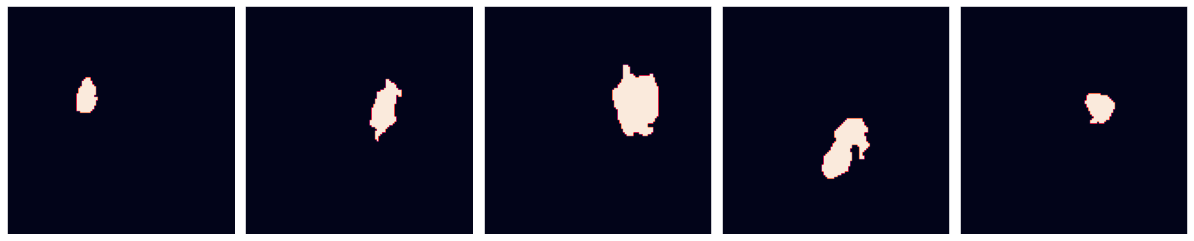

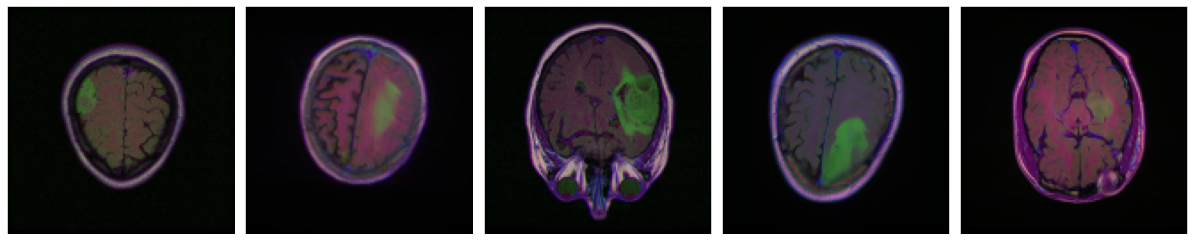

In [13]:
image_show_tensor(train_dataloader)

## Модель

Зададим модель на основе нейронной сети [**U-Net**](https://arxiv.org/pdf/1505.04597.pdf).

In [14]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear)        
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
unet = UNet(3, 1).to(device, dtype=torch.float)

## Обучение модели

Зададим функцию потерь - **бинарную кросс-энтропию**, по которой будет обучаться наша модель и метод оптимизации - **Adam**.

In [18]:
loss = nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE)

Далее обучим модель. Будем выводить значения функции потерь на каждой 5-ой эпохе для каждого датасета.

In [19]:
train_loss_history, valid_loss_history, test_loss_history = [], [], []

for epoch in range(EPOCH):
    
    train_batch_loss_history = []
    valid_batch_loss_history = []
    test_batch_loss_history = []
    
    for mask, image in train_dataloader:
        
        optimizer.zero_grad()
        
        mask = mask.to(device, dtype=torch.float)
        image = image.to(device, dtype=torch.float)
        
        pred = unet(image)
        loss_train = loss(pred, mask)
        
        loss_train.backward()
        
        train_batch_loss_history.append(loss_train.item())
        
        optimizer.step()
        
        del mask, image
            
    for mask, image in valid_dataloader:
                
        image = image.to(device,dtype=torch.float)
        mask = mask.to(device,dtype=torch.float)
                
        pred_valid = unet(image)
        loss_valid = loss(pred_valid, mask)
                
        valid_batch_loss_history.append(loss_valid.item())
        
        del mask, image
        
    for mask, image in test_dataloader:
                
        image = image.to(device,dtype=torch.float)
        mask = mask.to(device,dtype=torch.float)
                
        pred_test = unet(image)
        loss_test = loss(pred_test, mask)
                
        test_batch_loss_history.append(loss_test.item())
        
        del mask, image
                
    train_loss = np.mean(train_batch_loss_history)
    train_loss_history.append(train_loss)
    
    valid_loss = np.mean(valid_batch_loss_history)                          
    valid_loss_history.append(valid_loss)
    
    test_loss = np.mean(test_batch_loss_history)                          
    test_loss_history.append(test_loss)
                    
    
    if epoch % 5 == 0:

        print('{:4d} | train_loss:{:.4f} | valid_loss:{:.4f} | test_loss:{:.4f}'.format(epoch,
                                                                                        train_loss,
                                                                                        valid_loss,
                                                                                        test_loss))

   0 | train_loss:0.2350 | valid_loss:0.1176 | test_loss:0.1231
   5 | train_loss:0.0413 | valid_loss:0.0373 | test_loss:0.0441
  10 | train_loss:0.0310 | valid_loss:0.0353 | test_loss:0.0348
  15 | train_loss:0.0253 | valid_loss:0.0294 | test_loss:0.0321
  20 | train_loss:0.0225 | valid_loss:0.0235 | test_loss:0.0255
  25 | train_loss:0.0208 | valid_loss:0.0195 | test_loss:0.0226
  30 | train_loss:0.0172 | valid_loss:0.0176 | test_loss:0.0209
  35 | train_loss:0.0159 | valid_loss:0.0166 | test_loss:0.0189
  40 | train_loss:0.0145 | valid_loss:0.0200 | test_loss:0.0231
  45 | train_loss:0.0137 | valid_loss:0.0165 | test_loss:0.0170


Визуализируем показатели функции потерь в зависимости от эпохи обучения.

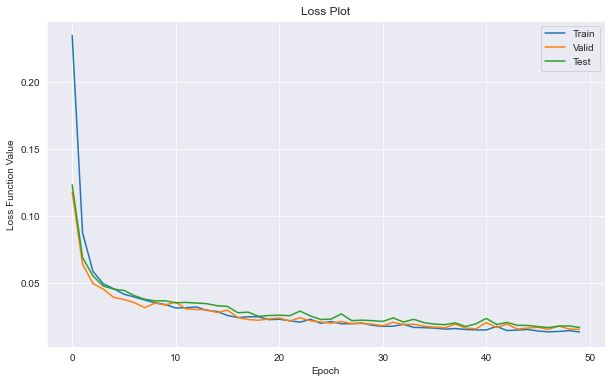

In [20]:
plt.subplots(figsize=(10, 6))

plt.plot(train_loss_history, label='Train')
plt.plot(valid_loss_history, label='Valid')
plt.plot(test_loss_history, label='Test')

plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.legend()

plt.show()

Как видно из приведенного графика явного переобучения модели не наблюдается. Функция потерь после нескольких эпох быстрого уменьшения выходит на плато. Это касается как значений на тренировочном наборе, так и валидационных и тестовых данных.

## Оценка полученных результатов

Выведим результаты работы нашей сети для тестового набора. Первым изображеним будет входное изображение МРТ из исходных данных - **Image**, далее будет идти реальная маска - **Mask**, а за ним предсазанное изображение выхода сети - **Prediction**, и в самом конце отфильрованное изображение (значения тензора *1x128x128*, которые больше **0.5**) - **Filtred Prediction**.

In [21]:
def singular_result(dataloader, model=unet, initial_index=0, cmap='viridis'):
    
    masks, images = next(iter(dataloader))

    prediction = unet(images.to(device,dtype=torch.float))
    filtred = (prediction>0.5).float()

    tensors = [images, masks, prediction, filtred]
    titles = ['Image', 'Mask', 'Prediction', 'Filtred Prediction']
    
    f, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    for tensor, title, i, j in zip(tensors, titles, [0, 0, 1, 1], [0, 1, 0, 1]): 
        
        tensor = tensor.cpu().detach().numpy().transpose(0,2,3,1)
        
        if tensor.shape[-1] == 1:        
            ax[i, j].imshow(tensor[initial_index], cmap=cmap)  
        else:
            ax[i, j].imshow(tensor[initial_index])
            
        ax[i, j].set_title(title)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

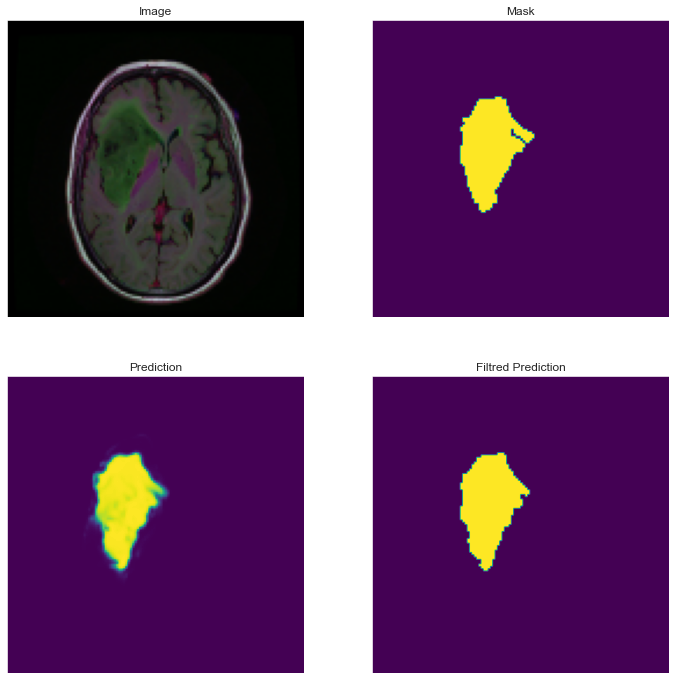

In [22]:
singular_result(test_dataloader)

## Вывод

Из исходных изображений мы выбрали только те образцы, где маска не была пустой (наличие пикселей со значениями больше нуля). После мы разделили данные на тренировочный, валидационный и тестовый наборы в пропорции **3:1:1**. Размер изображений был преобразован из *256x256* к *128x128*. После были применены методы аугментации - вертикальные и горизонтальные отражения. 

Далее была определена модель нейронной сети - **U-Net**, для которой в качестве функции потерь была задана **бинарная кросс-энтропия**. Методом оптимизации был задан алгоритм **Adam** с начальной скоростью обучения равной **1e-3**. 

Обучение модели производилось на **50-ти** эпохах, с размером батча, равным **10**. В ходе обучения результаты функции потерь дополнительно рассчитывали для валидационного и тестового наборов. На итоговом графике видно, что в рамках обучения отсутствует эффект явного переобучения модели. Результаты, вплоть до финальной эпохи, для каждого набора данных крайне слабо различаются между собой.